img shape,  (152, 167)
img stats, mean: 110.758, std: 7.259, median: 111.125


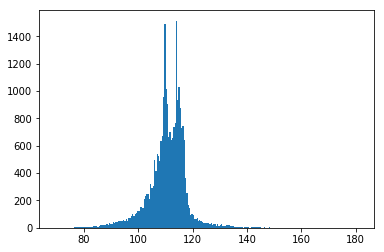

cell stat:  [4. 4.] , good label:  1


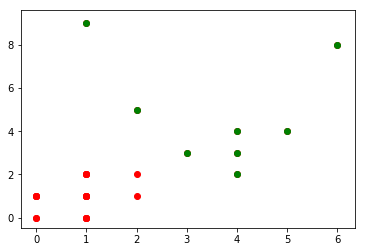

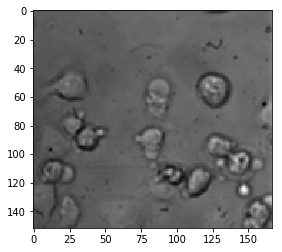

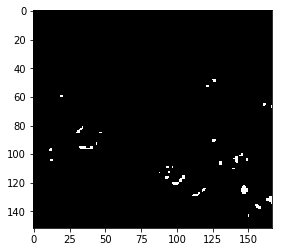

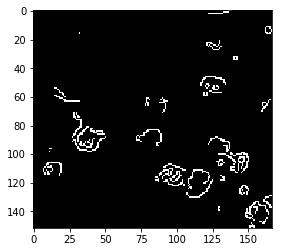

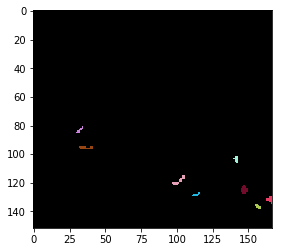

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import cv2
import queue

from sklearn import mixture

def getNeighbors(img, point):
    neighbors = []
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            n = (point[0] + i, point[1] + j)
            if n[0] > 0 and n[0] < img.shape[0] and n[1] > 0 and n[1] < img.shape[1]:
                neighbors.append(n)
    return neighbors

img = cv2.imread('stock_cells2.png',0)
print('img shape, ', img.shape)

edges = cv2.Canny(img,100,200)
img = img.astype(np.float32)
img = cv2.GaussianBlur(img, (3, 3), 0)

img_flat = np.ndarray.flatten(img)
print('img stats, mean: %.3f, std: %.3f, median: %.3f' % (img_flat.mean(), img_flat.std(), np.median(img_flat)))
plt.hist(img_flat, bins='auto')
plt.show()
img_median = np.median(img_flat)

threshold = 0.25
img_threshold = np.copy(img)
img_threshold[np.abs(img - img_median) <= threshold * img_median] = 0
img_threshold[np.abs(img - img_median) > threshold * img_median] = 256

img_bfs = np.copy(img_threshold)

cells = []
found_points = set()
q = queue.Queue()
for i in range(img_bfs.shape[0]):
    for j in range(img_bfs.shape[1]):
        point = (i, j)
        if img_bfs[point] != 256 or point in found_points:
            continue
            
        q.put(point)
        cell_list = []
        cell_list.append(point)
        while not q.empty():
            curr = q.get()
            
            for neighbor in getNeighbors(img_bfs, curr):
                if neighbor not in found_points and img_bfs[neighbor] == 256:
                    found_points.add(neighbor)
                    q.put(neighbor)
                    cell_list.append(neighbor)
        cells.append(cell_list)
        
img_color = np.zeros([img.shape[0], img.shape[1], 3])
i = 0
cell_stats = []
for cell in cells:
    i += 1
    cell_stats.append(np.max(cell, axis=0) - np.min(cell, axis=0))
cell_stats = np.array(cell_stats, dtype=np.float32)

GMM = mixture.GaussianMixture(2, covariance_type='spherical')
GMM.fit(cell_stats)
labels = GMM.predict(cell_stats)

good_label = 0
for i in range(len(labels)):
    if cell_stats[i][0] > cell_stats.mean():
        print('cell stat: ', cell_stats[i], ', good label: ', labels[i])
        good_label = labels[i]
        break

good_cell_stats = []
good_cells = []
for i in range(len(cell_stats)):
    if labels[i] != good_label:
        continue
    good_cell_stats.append(cell_stats[i])
    good_cells.append(cells[i])
    
for cset in good_cells:
    color = np.random.rand(3)
    for p in cset:
        img_color[p] = color
good_cell_stats = np.array(good_cell_stats, dtype=np.float32)
        
plt.scatter(cell_stats[:, 0], cell_stats[:, 1], color='red')
plt.scatter(good_cell_stats[:, 0], good_cell_stats[:, 1], color='g')
plt.show()

plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(img_threshold, cmap='gray')
plt.show()
plt.imshow(edges, cmap='gray')
plt.show()
plt.imshow(img_color)
plt.show()